#### Import some libraries

In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import pdist,squareform
%matplotlib inline

### Check the information in the csv file

In [2]:
data=pd.read_csv("TownCentre-groundtruth_top.csv",names=["numPersona","numFrame","headValid","bodyValid","headLeft","headTop"
                                                           ,"headRight","headBottom","bodyLeft","bodyTop","bodyRight",
                                                           "bodyBottom"])

In [3]:
data.head(10)

,numPersona,numFrame,headValid,bodyValid,headLeft,headTop,headRight,headBottom,bodyLeft,bodyTop,bodyRight,bodyBottom
0,0,0,1,1,270.828,794.098,309.037,834.066,235.925,770.142,371.546,1101.029
1,1,0,1,1,308.304,302.982,330.837,326.823,285.748,291.418,370.556,493.414
2,2,0,1,1,307.919,241.003,328.645,262.841,286.849,230.501,365.794,416.410
3,3,0,1,1,739.951,231.693,759.968,253.491,719.708,220.830,786.893,408.145
4,4,0,1,1,814.375,246.562,835.021,268.946,793.722,235.410,861.430,427.627
5,5,0,1,1,900.739,405.852,926.483,433.889,876.425,392.142,956.344,628.416
6,6,0,1,1,693.431,1028.397,736.904,1075.620,656.185,994.592,791.581,1387.335
7,7,0,1,1,1653.546,620.442,1686.481,655.497,1607.143,601.733,1717.096,892.799
8,8,0,1,1,1666.107,923.010,1710.000,968.739,1615.588,890.117,1748.101,1277.631
9,9,0,1,1,1832.710,183.865,1855.236,205.682,1790.455,174.285,1877.452,359.453


#### Display how many rows have non valid bodybounding boxes

In [4]:
len(data[data["bodyValid"]==0])

0

#### Display how many rows have non valid head bounding boxes

In [5]:
len(data[data["headValid"]==0])

0

#### Total frames in the video told by the csv file

In [6]:
len(data["numFrame"].drop_duplicates())

4501

#### Total frames in the video calculated

In [7]:
def frame_count(video_path, manual=False):
    def manual_count(handler):
        frames = 0
        while True:
            status, frame = handler.read()
            if not status:
                break
            frames += 1
        return frames 

    cap = cv2.VideoCapture(video_path)
    # Slow, inefficient but 100% accurate method 
    if manual:
        frames = manual_count(cap)
    # Fast, efficient but inaccurate method
    else:
        try:
            frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        except:
            frames = manual_count(cap)
    cap.release()
    return frames

In [8]:
print('frames_method1:', frame_count("TownCentreXVID.avi", manual=False))

frames_method1: 7500


In [9]:
print('frames_method2:', frame_count("TownCentreXVID.avi", manual=True))

frames_method2: 7498


The meaning is that we only have data of the bounding boxes for the first 4501 frames but not for the rest of frames. I will end the video when the video reaches the 4501 frame. Future work could be done to determine the bounding boxes for the rest of the video.

### Show the video with bounding boxes for head and body

I will also save an image to show the process of the perspective transformation.I will take the frame number 100

In [10]:
video = cv2.VideoCapture("TownCentreXVID.avi")

In [11]:
# Read until video is completed
frame_count=0
while(video.isOpened()):
    if frame_count==4502:
        break
    ret, frame = video.read()
            
    color_1 = (0,255,0)#BGR_GREEN
    color_2 = (0,255,0)#BGR_RED
    data_frame=data[data["numFrame"]==frame_count]
    for index, row in data_frame.iterrows():
        cv2.rectangle(frame, (int(row["bodyLeft"]), int(row["bodyTop"])), (int(row["bodyRight"]), int(row["bodyBottom"])), color_1, 2)
        cv2.rectangle(frame, (int(row["headLeft"]), int(row["headTop"])), (int(row["headRight"]), int(row["headBottom"])), color_2, 2)
   
    #Save a image to use for transformation
    if frame_count==100:
        cv2.imwrite('Test_image.jpg', frame)
        
    frame_resize = cv2.resize(frame, (960, 540))
    cv2.imshow('Frame',frame_resize)
    frame_count=frame_count+1
   
    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

video.release()
cv2.destroyAllWindows()

A **body bounding box** gives a better representation of the person, so I will work only with those.

### Make a tranformation of the perspective

I will use the image I saved from the previous block  to make the transformation and show the results.The image was taken from the frame 100.

#### Showing the rectangle chosen for the perspective

Rectangle chosen for the perspective transformation


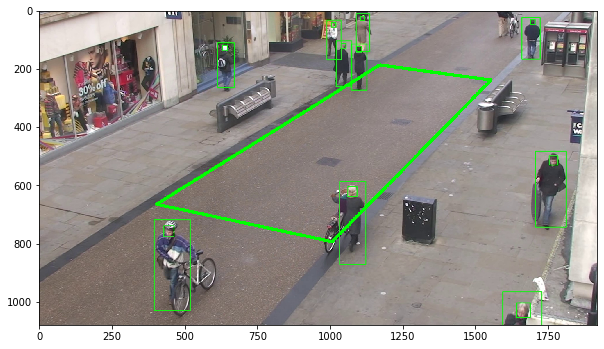

In [12]:
img = cv2.imread('Test_image.jpg')
img = img[:,:,::-1]
imgDibujo=img.copy()
width= 1920
height= 1080

# Points of the paviment to make bird_eye perspective
puntos= np.float32([[1172,185],[1555,237],[1008, 793],[404, 664]])
tl,tr,br,bl=puntos
pts = puntos.reshape((-1,1,2))
cv2.polylines(imgDibujo, [pts.astype(np.int32)], True, (0,255,0), thickness=10)
print("Rectangle chosen for the perspective transformation")
plt.figure(figsize=(10,10))
plt.imshow(imgDibujo)
plt.show()

#### Calculating  the size of the rectangle in the transformed image

In [13]:
#Let's find the max_width and max_height for the dimensions of our image transformation
width_bottom = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
width_top = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
max_width = max(int(width_bottom), int(width_top))


# Compute the height of the new image, which will be the maximum distance between the top-right and bottom-right
# y-coordinates or the top-left and bottom-left y-coordinates
height_right = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
height_left = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
max_height = max(int(height_right), int(height_left))

print("Max height in pixels: {}".format(max_height))
print("Max width in pixels: {}".format(max_width))



Max height in pixels: 905
Max width in pixels: 617


#### Show the change of perspective

I will add more size to the image, to show that we are missing some of the left part of the image

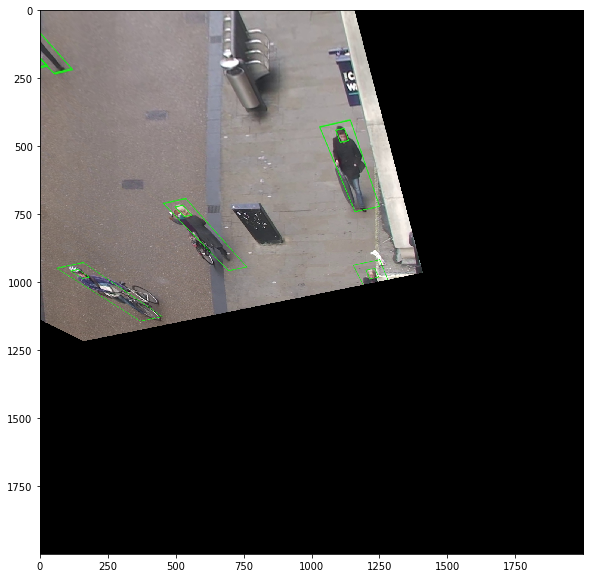

In [14]:
target = np.float32([[0,0],[max_width,0],[max_width,max_height],[0,max_height]])

#Calculation of the transformation matrix(H)
matrix = cv2.getPerspectiveTransform(puntos, target)
result = cv2.warpPerspective(img, matrix, (2000,2000))

plt.figure(figsize=(10,10))
plt.imshow(result)
plt.show()

This problem appear because the warpPerspective start the transformation taking **tl** as [0,0].We would need to make a translation in x and y to get the complete image.

To make sure that this point is clear I will transform the rectangle into the perspective image

Rectangle to perspective


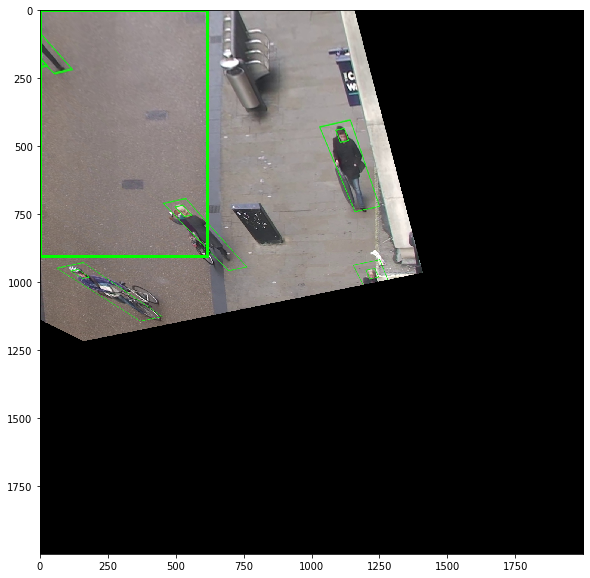

In [15]:
corners = np.float32([[0,0],[width,0],[width,height],[0,height]])
H=matrix #Just to link it with theory
result_copy=result.copy()
result_copy_2=result.copy()

rect_p = cv2.perspectiveTransform(puntos.reshape(-1,1,2), H)
print("Rectangle to perspective")
cv2.polylines(result_copy, [rect_p.astype(np.int32)], True, (0,255,0), thickness=10)
plt.figure(figsize=(10,10))
plt.imshow(result_copy)
plt.show()



#### Transforming the corners of the original image to perspective

Image corners to perspective
[[[-2467.989      -82.058334]]

 [[  881.23865  -1055.6709  ]]

 [[ 1407.6661     965.459   ]]

 [[  160.98381   1217.5995  ]]]


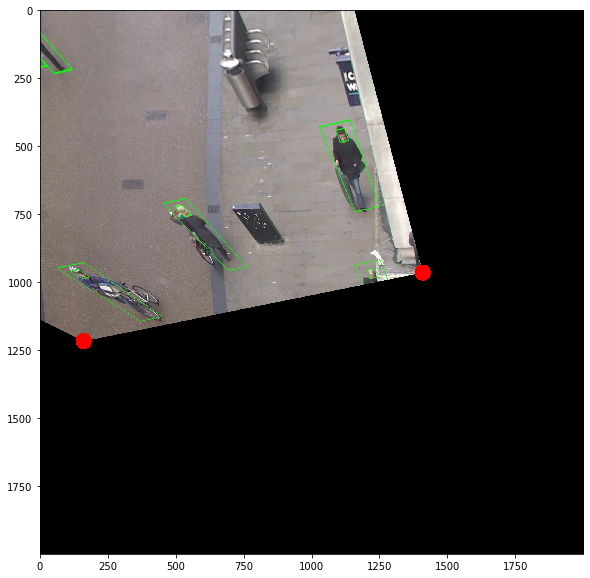

In [16]:
corner_p = cv2.perspectiveTransform(corners.reshape(-1,1,2), H)
print("Image corners to perspective")
print(corner_p)
for i in range(0, 4):
    cv2.circle(result_copy_2, tuple(corner_p[i].ravel()), 30, (255,0,0), -1)
plt.figure(figsize=(10,10))
plt.imshow(result_copy_2)
plt.show()


#### Show the entire image in the perspective view

To to this is important to know the size of the image in the perspective view.Also, it is important to change the H matriz to make the corresponding translation in x and y.

Complete image to perspective
Width: 3874
Height: 2272
Aspect ratio: 1.705105633802817


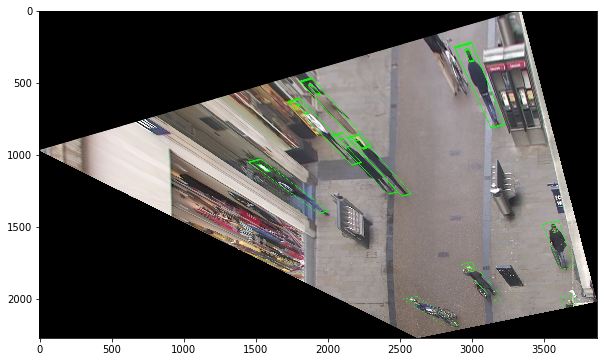

In [17]:
#Find the correct size to plot all the image
[xmin, ymin] = np.int32(corner_p.min(axis=0).ravel())
[xmax, ymax] = np.int32(corner_p.max(axis=0).ravel())
width_complete=xmax-xmin
heigth_complete=ymax-ymin

#Find the parameters for translation of the image
trans_x=0-xmin
trans_y=0-ymin

#Remeber that you can add diferent transformations by making the dot product of the transformation matrixes. Ht=H1.H2
Htrans = np.array([[1,0,trans_x],[0,1,trans_y],[0,0,1]]) # translate x->trans_x  and y->trans_y 
Htrans_complete=Htrans.dot(H)

result_2 = cv2.warpPerspective(img, Htrans_complete, (width_complete, heigth_complete))
print("Complete image to perspective")
print("Width: {}".format(width_complete))
print("Height: {}".format(heigth_complete))
print("Aspect ratio: {}".format(width_complete/heigth_complete))
plt.figure(figsize=(10,10))
plt.imshow(result_2)
plt.show()

Looking the image, I do not need the first 1700 pixels of the left part of the image because it doesn't give me information.
I will translate the image 1700 pixels to the left

Partial image to perspective
Width: 2174
Height: 2272
Aspect ratio: 0.9568661971830986


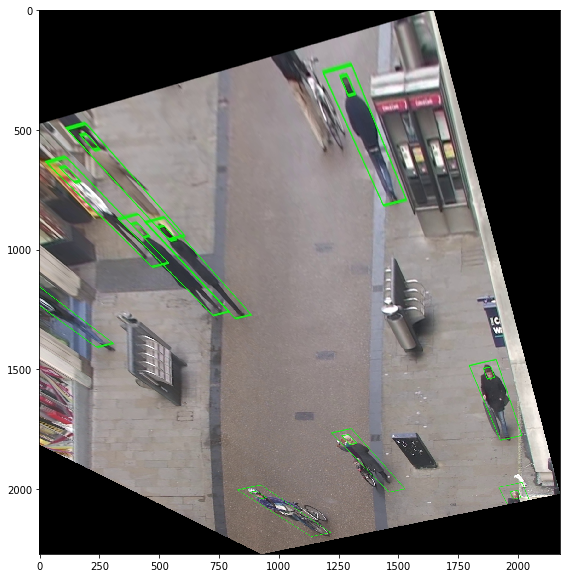

In [18]:
x_left=1700
Hleft = np.array([[1,0,-x_left],[0,1,0],[0,0,1]]) # translate
Htrans_partial= Hleft.dot(Htrans_complete)

width_partial=width_complete-x_left
heigth_partial=heigth_complete
size_partial=(width_partial,heigth_partial)
result_3 = cv2.warpPerspective(img, Htrans_partial, (width_partial, heigth_partial))

print("Partial image to perspective")
print("Width: {}".format(width_partial))
print("Height: {}".format(heigth_partial))
print("Aspect ratio: {}".format(width_partial/heigth_partial))
plt.figure(figsize=(10,10))
plt.imshow(result_3)
plt.show()

The important information: 
- Htrans_partial
- width_partial
- heigth_partial
- size partial


### Calculate the distance( in pixels) in the perspective image

I obtained the measure of the width of the street using Google Earth. I took two points from the image, and that will be my reference for the 5.4m of the width of the street. 

In [19]:
puntos_distancia= np.float32([[1172,185],[1555,237]]) #Reference points to calculate distance between points.The distance is 5meters
puntos_distancia_p=cv2.perspectiveTransform(puntos_distancia.reshape(-1,1,2),Htrans_partial)

d_5m=pdist(puntos_distancia_p.reshape(-1,2))[0] #Exactly 5.4m
d_2m=d_5m*2/5.4
d_3_5m=d_5m*3.5/5.4


print("Distance 5 meters in pixels: {}".format(d_5m))
print("Distance 3.5 meters in pixels: {}".format(d_3_5m))
print("Distance 2 meters in pixels: {}".format(d_2m))


Distance 5 meters in pixels: 617.0
Distance 3.5 meters in pixels: 399.9074074074074
Distance 2 meters in pixels: 228.5185185185185


### Making the complete bird eye view

To make the bird eye view I used the following functions:

In [20]:
def plot_lines_cirles_threshold(matrix_dist,coordinates_pespective,black_image,operation,minimum,maximum=0):
    """
    Purpose: Draw circles and lines between points that follow a certain operation(less than,greater,between).Also,
    return the information of the points and the pair of points.  
    
    Input:
    -matrix_dist: Matrix of distances between points
    -coordinates_pespective: Array that contains the cordinates of all the points in the perspective image
    -black_image:Image to plot the lines and circles
    -operation: Defines which operation to extract from the matrix of distances
    -minimum:Integer for the minimum distance in pixels
    -maximum:Integer for the maximum distance in pixels
    
    Output:
    -black_image: Return the image with the lines and circles
    -dd_t_points: array with the indexes of points in coordinates_perspective that followed the operation
    -dd_t_pairs: array with the indexes of the pair of points that followed the operation
    """
    
    
    
    #Determine index of pairs that follow the operation
    if operation=="less than":
        dd_t=np.where(matrix_dist<=minimum)
        color=(0,0,255)
    elif  operation=="greater":
        dd_t=np.where(matrix_dist>minimum)
        color=(0,255,0)
    else:
        dd_t=np.where((matrix_dist>minimum)&(matrix_dist<=maximum))
        color=(0,255,255)
    
    lineThickness = 18
    dd_t_points=[]
    dd_t_pairs=[]
    if operation!="greater":
        #Plot line between pairs
        for i in range(len(dd_t[0])):
            if dd_t[0][i]!=dd_t[1][i]: 
                cv2.line(black_image, tuple(coordinates_pespective[dd_t[0][i]]),tuple(coordinates_pespective[dd_t[1][i]]),
                                                                                      color, lineThickness)
                dd_t_points.append(dd_t[0][i])
                dd_t_points.append(dd_t[1][i])
                dd_t_pairs.append([dd_t[0][i],dd_t[1][i]])
    else:
        for i in range(len(dd_t[0])):
            if dd_t[0][i]!=dd_t[1][i]:
                dd_t_points.append(dd_t[0][i])
                dd_t_points.append(dd_t[1][i])
                dd_t_pairs.append([dd_t[0][i],dd_t[1][i]])
                
    #Determine all points related to 2m distance ans plot the circles
    dd_t_points=list(set(dd_t_points))
    
    for index in dd_t_points:
        cv2.circle(black_image, tuple(coordinates_pespective[index]), 30, color, -1)
    
    return black_image,dd_t_points,dd_t_pairs

In [21]:
def img_bird_eye(data):
    """
    Purpose: From the data frame extract the information to draw the points in the perspective image.Also, return arrays
    with the points and pair of points drawn with different colors.I was thinking in using yellow for an intermidiate distance
    but the information was not observed very well.
    
    Input:
    -data: Information of the bounding boxes for the current frame
    
    Output:
    -black_image: Return the image with the lines and circles
    -dd_red: Array with the indexes of the points drawn in red 
    -dd_green: Array with the indexes of the points drawn in green 
    -dd_red_pairs: Array with the indexes of the pairs of points that draw a line in red 
    -dd_green_pairs: Array with the indexes of the pairs of points that draw a line in green 
    """
    
    
    y=np.array(data["bodyBottom"])
    x=np.array((data["bodyLeft"]+data["bodyRight"])/2)
    coordinates=np.array(list(zip(x,y)))
    
    #Passing coordinates to the perspective view
    coordinates_pespective = cv2.perspectiveTransform(coordinates.reshape(-1,1,2), Htrans_partial)
    coordinates_pespective=coordinates_pespective.astype(int)
    
    #Black background
    black_image = np.zeros((heigth_partial,width_partial,3),np.uint8)
    
    #Matrix of distances between points
    coordinates_pespective=coordinates_pespective.reshape(-1,2)
    matrix_dist=squareform(pdist(coordinates_pespective))
    
    #POINTS AND LINES WITH DISTANCE GREATER THAN 3.5 METERS
    black_image,dd_green,dd_green_pairs=plot_lines_cirles_threshold(matrix_dist,coordinates_pespective,black_image,"greater",d_2m)
    """
    The visual representation was messy so i would not add this part
    #POINTS AND LINES WITH DISTANCE GREATER THAN 2 METERS AND LESS THAN 3.5
    black_image,dd_yellow,dd_yellow_pairs=plot_lines_cirles_threshold(matrix_dist,coordinates_pespective,black_image,"range",d_2m,d_3_5m)
    """
    #POINTS AND LINES WITH DISTANCE LESS OR EQUAL THAN 2 METERS
    black_image,dd_red,dd_red_pairs=plot_lines_cirles_threshold(matrix_dist,coordinates_pespective,black_image,"less than",d_2m)
    
    
    return black_image,dd_red,dd_green,dd_red_pairs,dd_green_pairs



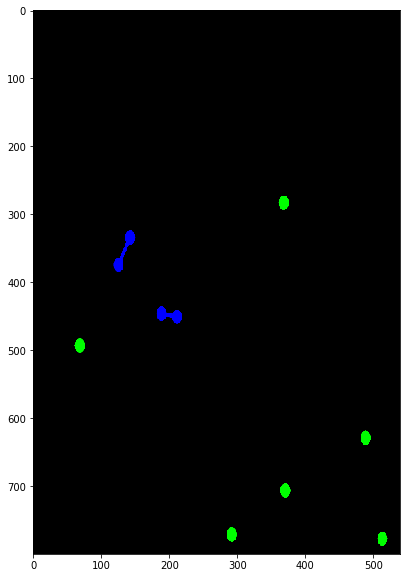

Values inside dd_red:
[8, 1, 2, 6]


In [22]:
black_image,dd_red,dd_green,_,_=img_bird_eye(data[data["numFrame"]==100])
frame_resize = cv2.resize(black_image, (540, 800)) #Poner 1.47 aspect ratio
plt.figure(figsize=(10,10))
plt.imshow(frame_resize)
plt.show()
print("Values inside dd_red:")
print(dd_red)

### Final result 

#### Preparing the background image for the presentation

In [23]:
color_gray=(168,168,168)#(198,211,205)
top_title = np.ones((60,1920,3),np.uint8)*255
gray_background=np.ones((800,520,3),np.uint8)
video=np.zeros((800,1400,3),np.uint8)
bird=np.zeros((640,440,3),np.uint8)

In [24]:
special_gray=[168,168,168]
for i in range(3):
    gray_background[:,:,i]=gray_background[:,:,i]*special_gray[i]

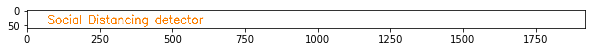

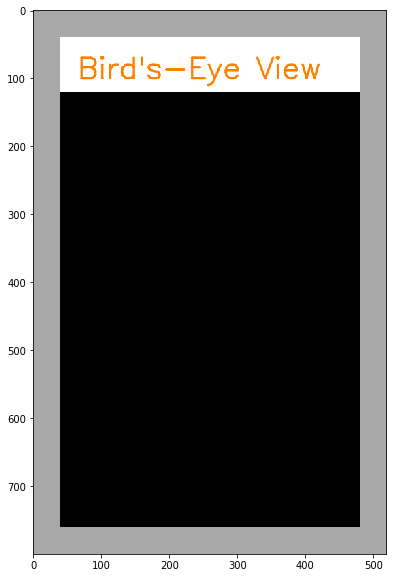

In [25]:
text_color=(255,128,0)
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 1.3
thickness = 2

#Text in the principal rectangle
cv2.putText(top_title, "Social Distancing detector" , (70,45), font,fontScale, text_color, thickness, cv2.LINE_AA)
plt.figure(figsize=(10,10))
plt.imshow(top_title)
plt.show()

#Text inside a white rectangle and the bird eye
fontScale = 1.45
thickness = 2
y_offset=120
x_offset=40
cv2.rectangle(gray_background, (40,40),(480,120),(255,255,255), -1)
cv2.putText(gray_background, "Bird's-Eye View" , (65,100), font,fontScale, text_color, thickness, cv2.LINE_AA)
gray_background[y_offset:y_offset+bird.shape[0], x_offset:x_offset+bird.shape[1]] = bird


plt.figure(figsize=(10,10))
plt.imshow(gray_background)
plt.show()

Shape of image for presentation: (860, 1920, 3)


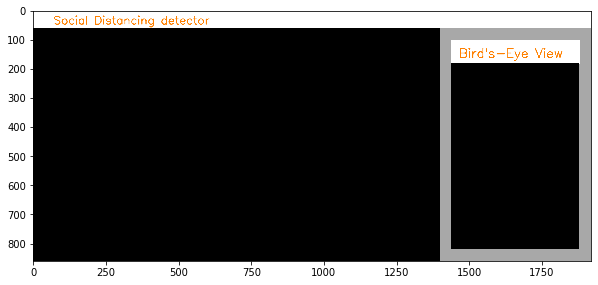

In [26]:
part_1=np.concatenate((video,gray_background),axis=1)
presentation=np.concatenate((top_title,part_1),axis=0)
print("Shape of image for presentation: {}".format(presentation.shape))
plt.figure(figsize=(10,10))
plt.imshow(presentation)
plt.show()

#### Record the processed video, the bird eye image and the final presentation as .avi videos

I will save the image from the frame 100 for the presentation

In [27]:
video = cv2.VideoCapture("TownCentreXVID.avi")
fps = video.get(cv2.CAP_PROP_FPS)
out_presentation = cv2.VideoWriter('presentation.avi', cv2.VideoWriter_fourcc('M','J','P','G'), fps, (1920,860))
out_bird = cv2.VideoWriter('bird_eye.avi', cv2.VideoWriter_fourcc('M','J','P','G'), fps, (540,960))
out_video = cv2.VideoWriter('video.avi', cv2.VideoWriter_fourcc('M','J','P','G'), fps, (960,540))

In [28]:
# Read until video is completed
frame_count=0
presentation_frame=presentation.copy()
birdy_offset=120+60
birdx_offset=40+1400

videoy_offset=60
videox_offset=0

color_r = (0,0,255)
color_g = (0,255,0)
color_y = (0,255,255)
color_gray=(198,211,205)
text_color=(255,128,0)

annotations_color=(255,255,255)
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.75
thickness = 2
while(video.isOpened()):
    if frame_count==4501:
        break
        
    ret, frame = video.read()
    
    data_frame=data[data["numFrame"]==frame_count]
    #--------------------------------- 
    #Calculate and plot the bird eye
    #--------------------------------- 
    bird_eye,dd_red,dd_green,dd_red_pairs,dd_green_pairs=img_bird_eye(data_frame)
    #Include bird_eye in the presentation image
    #bird_eye_presentation = cv2.resize(bird_eye, (440, 640))
    bird_eye_presentation = cv2.resize(bird_eye, (440, 640))
    presentation_frame[birdy_offset:birdy_offset+bird_eye_presentation.shape[0],
                 birdx_offset:birdx_offset+bird_eye_presentation.shape[1]] = bird_eye_presentation
    
    #Save bird_eye as another output video
    bird_eye_other = cv2.resize(bird_eye, (540,960))
    out_bird.write(bird_eye_other)
    cv2.imshow('Bird eye',bird_eye_other)
    
    #------------------------------------------------ 
    #Show bounding boxes with information of distance
    #------------------------------------------------
    
    #Calculate the middle point of the bounding boxes
    y=np.array((data_frame["bodyBottom"]+data_frame["bodyTop"])/2).astype(np.int32)
    x=np.array((data_frame["bodyLeft"]+data_frame["bodyRight"])/2).astype(np.int32)
    coordinates=np.array(list(zip(x,y)))
    
    #Show the bounding boxes with color depending on the social distancing 
    lineThickness = 4
    for index, row in data_frame.reset_index().iterrows():
        if index in dd_red:
            color=color_r
        elif index in dd_green:
            color=color_g
        else:
            color=color_y
        cv2.rectangle(frame, (int(row["bodyLeft"]), int(row["bodyTop"])), (int(row["bodyRight"]), int(row["bodyBottom"])),
                      color, 2)
        
    #Show lines between red bounding boxes 
    for pair_r in dd_red_pairs:
        cv2.line(frame, tuple(coordinates[pair_r[0]]),tuple(coordinates[pair_r[1]]),color_r, lineThickness)
    
    #Include video in the presentation image
    frame_presentation = cv2.resize(frame, (1400,800))
    presentation_frame[videoy_offset:videoy_offset+frame_presentation.shape[0],
                 videox_offset:videox_offset+frame_presentation.shape[1]] = frame_presentation
    
    
    #Save video with bounding boxes as another output video
    frame_resize = cv2.resize(frame, (960, 540))
    out_video.write(frame_resize)
    cv2.imshow('Frame',frame_resize)
    
    #Show final presentation video, adding some borders and annotations
    cv2.rectangle(presentation_frame, (0,0),(1920,860),text_color, 2)
    cv2.line(presentation_frame, (0,60),(1920,60),text_color,2)
    cv2.line(presentation_frame, (1400,60),(1400,860),text_color,2)
    
    cv2.rectangle(presentation_frame, (970,80),(1390,115),annotations_color, -1)
    cv2.rectangle(presentation_frame, (970,80),(1390,115),text_color, 2)
    cv2.putText(presentation_frame, "Irresponsable people index: {:.1%}".format(len(dd_red)/len(data_frame)) ,
                (980,105), font,fontScale, text_color, thickness, cv2.LINE_AA)
    
    out_presentation.write(presentation_frame)
    presentation_resize = cv2.resize(presentation_frame, (960, 430))
    cv2.imshow('Presentation',presentation_resize)
    
    #Save frame 100 for the presentation
    if frame_count==100:
        cv2.imwrite("Final presentation.jpg",presentation_frame)

    frame_count=frame_count+1
    # Press Q on keyboard to  exit
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

video.release()
out_presentation.release()
out_bird.release()
out_video.release()
cv2.destroyAllWindows()

#### Show people bounding boxes using MobileNetSSD

Credits: Ivan Sipiran

This part of the code is an example  of people detection using MobileNetSSD.At the moment, it is not linked with the bird eye view.

In [4]:
from tracker.centroidtracker import CentroidTracker
from tracker.trackableobject import TrackableObject
from imutils.video import VideoStream
from imutils.video import FPS
import numpy as np
import argparse
import imutils
import time
import dlib #Kernelized correlation filter
import cv2

In [13]:
from tracker.centroidtracker import CentroidTracker
from tracker.trackableobject import TrackableObject
prototxt_file = 'mobilenet_ssd/MobileNetSSD_deploy.prototxt'
model_file = 'mobilenet_ssd/MobileNetSSD_deploy.caffemodel'
input_file = 'TownCentreXVID.avi'
output_file = 'output_detect.avi'
conf = 0.2
skip_frames = 30

#Lista de clases con la que fue entrenada MobileNet y SSD

CLASSES = ["background", "aeroplane", "bicycle", "bird", "boat",
           "bottle", "bus", "car", "cat", "chair", "cow", "diningtable",
           "dog", "horse", "motorbike", "person", "pottedplant", "sheep",
           "sofa", "train", "tvmonitor"]


# Cargar modelo serializado en Caffe
print("[INFO] Cargando...")
net = cv2.dnn.readNetFromCaffe(prototxt_file, model_file)

print("[INFO] Abriendo video...")
vs = cv2.VideoCapture(input_file)

# Inicializar el video writer
writer = None

# Dimensiones de la imagen se extraen del primer frame
W = None
H = None

# Instanciar el tracker
ct = CentroidTracker(maxDisappeared=40, maxDistance=50)

#Lista de objetos y diccionario para los ID's
trackers = []
trackableObjects = {}

# Numero total de frames, numero de objetos que fueron hacia abajo y hacia arriba
totalFrames = 0
totalDown = 0
totalUp = 0

# Iniciar el estimador de fps
fps = FPS().start()

# Bucle sobre los frames del video
while True:
  #Obtener el frame del video
    _,frame = vs.read()
  
    # Si el frame es vacio, se acabo el video
    if frame is None:
        break
    if totalFrames<=4501:
        totalFrames += 1
        fps.update()
        continue
        
    # Escalar imagen
    frame = imutils.resize(frame, width=720,height=576)
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    if W is None or H is None:
        (H, W) = frame.shape[:2]

    # Inicializar el writer
    if writer is None:
        fourcc = cv2.VideoWriter_fourcc(*"MP4V")
        writer = cv2.VideoWriter(output_file, fourcc, 30, (W, H), True)

    # Inicializar el estado de la aplicacion, junto con la lista de rectangulos
    # ya sea del detector o del tracker
    status = "Waiting"
    rects = []

    # Chequear si debemos correr el detector o el tracker
    if totalFrames % skip_frames == 0:
        # Correr el detector
        status = "Detecting"
        trackers = []

        # Convertir el frame a un blob y enviarlo a la red
        blob = cv2.dnn.blobFromImage(frame, 0.007843, (W, H), 127.5)
        net.setInput(blob)
        detections = net.forward()

        # Iterar sobre las detecciones
        for i in np.arange(0, detections.shape[2]):
            # Extraer la confidencia
            confidence = detections[0, 0, i, 2]

            # Filtrar la confidencia
            if confidence > conf:

                # Extraer la clase de la deteccion
                idx = int(detections[0, 0, i, 1])

                # Si la clase no es persona, ignorarlo
                if CLASSES[idx] != "person":
                    continue

                # Computer las coordenadas del rectangulo de deteccion
                box = detections[0, 0, i, 3:7] * np.array([W, H, W, H])
                (startX, startY, endX, endY) = box.astype("int")
                cv2.rectangle(frame, (startX, startY), (endX, endY),(255,255,0), 2)

                # Usar dlib para crear un tracker sobre el objeto detectado
                tracker = dlib.correlation_tracker()
                rect = dlib.rectangle(startX, startY, endX, endY)
                tracker.start_track(rgb, rect)

                # Acumular el tracker
                trackers.append(tracker)

    # Sino utilizamos el tracker
    else:
        for tracker in trackers:
            status = "Tracking"
            tracker.update(rgb)
            pos = tracker.get_position()

            # unpack the position object
            startX = int(pos.left())
            startY = int(pos.top())
            endX = int(pos.right())
            endY = int(pos.bottom())
            
            cv2.rectangle(frame, (startX, startY), (endX, endY),(0,255,0), 2)
            
        # Añadir el bounding box a la lista de rectangulos
            rects.append((startX, startY, endX, endY))

    # Actualizar informacion de los centroides de los bbox
    objects = ct.update(rects)

    
    if writer is not None:
        writer.write(frame)

    # Actualizar el FPS
    totalFrames += 1
    fps.update()

# Detener el FPS
fps.stop()
print("[INFO] Tiempo transcurrido: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

if writer is not None:
    writer.release()

vs.release()

[INFO] Cargando...
[INFO] Abriendo video...
[INFO] Tiempo transcurrido: 671.81
[INFO] approx. FPS: 11.16
